# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

 8462336/11490434 [=====================>........] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 10:59 - loss: 0.6951

  31/1875 [..............................] - ETA: 3s - loss: 0.5381   

  72/1875 [>.............................] - ETA: 2s - loss: 0.4434

 115/1875 [>.............................] - ETA: 2s - loss: 0.3985

 157/1875 [=>............................] - ETA: 2s - loss: 0.3716

 198/1875 [==>...........................] - ETA: 2s - loss: 0.3527

 243/1875 [==>...........................] - ETA: 2s - loss: 0.3365

 289/1875 [===>..........................] - ETA: 1s - loss: 0.3232

 328/1875 [====>.........................] - ETA: 1s - loss: 0.3137

 367/1875 [====>.........................] - ETA: 1s - loss: 0.3055

 407/1875 [=====>........................] - ETA: 1s - loss: 0.2980

 447/1875 [======>.......................] - ETA: 1s - loss: 0.2913

 491/1875 [======>.......................] - ETA: 1s - loss: 0.2847

 536/1875 [=======>......................] - ETA: 1s - loss: 0.2786

 582/1875 [========>.....................] - ETA: 1s - loss: 0.2729

 629/1875 [=========>....................] - ETA: 1s - loss: 0.2677

 674/1875 [=========>....................] - ETA: 1s - loss: 0.2631

 719/1875 [==========>...................] - ETA: 1s - loss: 0.2589

 765/1875 [===========>..................] - ETA: 1s - loss: 0.2548

 811/1875 [===========>..................] - ETA: 1s - loss: 0.2511

 855/1875 [============>.................] - ETA: 1s - loss: 0.2478

 895/1875 [=============>................] - ETA: 1s - loss: 0.2449

 935/1875 [=============>................] - ETA: 1s - loss: 0.2422

 968/1875 [==============>...............] - ETA: 1s - loss: 0.2400

1004/1875 [===============>..............] - ETA: 1s - loss: 0.2378

1040/1875 [===============>..............] - ETA: 1s - loss: 0.2357

1068/1875 [================>.............] - ETA: 0s - loss: 0.2341

1102/1875 [================>.............] - ETA: 0s - loss: 0.2322

1132/1875 [=================>............] - ETA: 0s - loss: 0.2306

1162/1875 [=================>............] - ETA: 0s - loss: 0.2290

1197/1875 [==================>...........] - ETA: 0s - loss: 0.2273

1231/1875 [==================>...........] - ETA: 0s - loss: 0.2256

1269/1875 [===================>..........] - ETA: 0s - loss: 0.2239

1298/1875 [===================>..........] - ETA: 0s - loss: 0.2225

1335/1875 [====================>.........] - ETA: 0s - loss: 0.2209

1369/1875 [====================>.........] - ETA: 0s - loss: 0.2195

1408/1875 [=====================>........] - ETA: 0s - loss: 0.2179

1439/1875 [======================>.......] - ETA: 0s - loss: 0.2167

1479/1875 [======================>.......] - ETA: 0s - loss: 0.2151

1517/1875 [=======================>......] - ETA: 0s - loss: 0.2137

1557/1875 [=======================>......] - ETA: 0s - loss: 0.2123

1595/1875 [========================>.....] - ETA: 0s - loss: 0.2109

1634/1875 [=========================>....] - ETA: 0s - loss: 0.2096

1672/1875 [=========================>....] - ETA: 0s - loss: 0.2083

1711/1875 [==========================>...] - ETA: 0s - loss: 0.2071

1749/1875 [==========================>...] - ETA: 0s - loss: 0.2059

1788/1875 [===========================>..] - ETA: 0s - loss: 0.2047

1826/1875 [============================>.] - ETA: 0s - loss: 0.2036

1864/1875 [============================>.] - ETA: 0s - loss: 0.2025

1875/1875 [==============================] - 3s 1ms/step - loss: 0.2022


Epoch 2/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0987

  39/1875 [..............................] - ETA: 2s - loss: 0.1097

  78/1875 [>.............................] - ETA: 2s - loss: 0.1093

 116/1875 [>.............................] - ETA: 2s - loss: 0.1091

 153/1875 [=>............................] - ETA: 2s - loss: 0.1089

 192/1875 [==>...........................] - ETA: 2s - loss: 0.1089

 230/1875 [==>...........................] - ETA: 2s - loss: 0.1088

 268/1875 [===>..........................] - ETA: 2s - loss: 0.1087

 307/1875 [===>..........................] - ETA: 2s - loss: 0.1086

 345/1875 [====>.........................] - ETA: 2s - loss: 0.1085

 383/1875 [=====>........................] - ETA: 1s - loss: 0.1084

 421/1875 [=====>........................] - ETA: 1s - loss: 0.1083

 460/1875 [======>.......................] - ETA: 1s - loss: 0.1083

 498/1875 [======>.......................] - ETA: 1s - loss: 0.1082

 536/1875 [=======>......................] - ETA: 1s - loss: 0.1081

 569/1875 [========>.....................] - ETA: 1s - loss: 0.1080

 602/1875 [========>.....................] - ETA: 1s - loss: 0.1080

 635/1875 [=========>....................] - ETA: 1s - loss: 0.1079

 669/1875 [=========>....................] - ETA: 1s - loss: 0.1078

 707/1875 [==========>...................] - ETA: 1s - loss: 0.1077

 747/1875 [==========>...................] - ETA: 1s - loss: 0.1076

 786/1875 [===========>..................] - ETA: 1s - loss: 0.1076

 825/1875 [============>.................] - ETA: 1s - loss: 0.1075

 865/1875 [============>.................] - ETA: 1s - loss: 0.1074

 904/1875 [=============>................] - ETA: 1s - loss: 0.1073

 943/1875 [==============>...............] - ETA: 1s - loss: 0.1072

 983/1875 [==============>...............] - ETA: 1s - loss: 0.1072

1022/1875 [===============>..............] - ETA: 1s - loss: 0.1071

1062/1875 [===============>..............] - ETA: 1s - loss: 0.1070

1098/1875 [================>.............] - ETA: 1s - loss: 0.1069

1127/1875 [=================>............] - ETA: 1s - loss: 0.1069

1162/1875 [=================>............] - ETA: 0s - loss: 0.1068

1200/1875 [==================>...........] - ETA: 0s - loss: 0.1067

1233/1875 [==================>...........] - ETA: 0s - loss: 0.1067

1270/1875 [===================>..........] - ETA: 0s - loss: 0.1066

1307/1875 [===================>..........] - ETA: 0s - loss: 0.1066

1345/1875 [====================>.........] - ETA: 0s - loss: 0.1065

1385/1875 [=====================>........] - ETA: 0s - loss: 0.1064

1425/1875 [=====================>........] - ETA: 0s - loss: 0.1064

1465/1875 [======================>.......] - ETA: 0s - loss: 0.1063

1504/1875 [=======================>......] - ETA: 0s - loss: 0.1062

1544/1875 [=======================>......] - ETA: 0s - loss: 0.1062

1584/1875 [========================>.....] - ETA: 0s - loss: 0.1061

1624/1875 [========================>.....] - ETA: 0s - loss: 0.1060

1664/1875 [=========================>....] - ETA: 0s - loss: 0.1060

1704/1875 [==========================>...] - ETA: 0s - loss: 0.1059

1743/1875 [==========================>...] - ETA: 0s - loss: 0.1058

1783/1875 [===========================>..] - ETA: 0s - loss: 0.1058

1823/1875 [============================>.] - ETA: 0s - loss: 0.1057

1863/1875 [============================>.] - ETA: 0s - loss: 0.1057

1875/1875 [==============================] - 3s 1ms/step - loss: 0.1056


Epoch 3/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0993

  40/1875 [..............................] - ETA: 2s - loss: 0.0977

  80/1875 [>.............................] - ETA: 2s - loss: 0.0978

 120/1875 [>.............................] - ETA: 2s - loss: 0.0978

 159/1875 [=>............................] - ETA: 2s - loss: 0.0979

 199/1875 [==>...........................] - ETA: 2s - loss: 0.0979

 239/1875 [==>...........................] - ETA: 2s - loss: 0.0980

 279/1875 [===>..........................] - ETA: 2s - loss: 0.0980

 319/1875 [====>.........................] - ETA: 1s - loss: 0.0980

 359/1875 [====>.........................] - ETA: 1s - loss: 0.0980

 399/1875 [=====>........................] - ETA: 1s - loss: 0.0980

 439/1875 [======>.......................] - ETA: 1s - loss: 0.0980

 479/1875 [======>.......................] - ETA: 1s - loss: 0.0980

 519/1875 [=======>......................] - ETA: 1s - loss: 0.0980

 558/1875 [=======>......................] - ETA: 1s - loss: 0.0980

 597/1875 [========>.....................] - ETA: 1s - loss: 0.0980

 637/1875 [=========>....................] - ETA: 1s - loss: 0.0980

 677/1875 [=========>....................] - ETA: 1s - loss: 0.0980

 717/1875 [==========>...................] - ETA: 1s - loss: 0.0980

 756/1875 [===========>..................] - ETA: 1s - loss: 0.0980

 796/1875 [===========>..................] - ETA: 1s - loss: 0.0979

 836/1875 [============>.................] - ETA: 1s - loss: 0.0979

 876/1875 [=============>................] - ETA: 1s - loss: 0.0979

 915/1875 [=============>................] - ETA: 1s - loss: 0.0979

 954/1875 [==============>...............] - ETA: 1s - loss: 0.0979

 993/1875 [==============>...............] - ETA: 1s - loss: 0.0979

1033/1875 [===============>..............] - ETA: 1s - loss: 0.0978

1073/1875 [================>.............] - ETA: 1s - loss: 0.0978

1112/1875 [================>.............] - ETA: 0s - loss: 0.0978

1152/1875 [=================>............] - ETA: 0s - loss: 0.0978

1191/1875 [==================>...........] - ETA: 0s - loss: 0.0978

1231/1875 [==================>...........] - ETA: 0s - loss: 0.0978

1271/1875 [===================>..........] - ETA: 0s - loss: 0.0978

1311/1875 [===================>..........] - ETA: 0s - loss: 0.0978

1351/1875 [====================>.........] - ETA: 0s - loss: 0.0978

1389/1875 [=====================>........] - ETA: 0s - loss: 0.0978

1428/1875 [=====================>........] - ETA: 0s - loss: 0.0977

1467/1875 [======================>.......] - ETA: 0s - loss: 0.0977

1507/1875 [=======================>......] - ETA: 0s - loss: 0.0977

1546/1875 [=======================>......] - ETA: 0s - loss: 0.0977

1585/1875 [========================>.....] - ETA: 0s - loss: 0.0977

1624/1875 [========================>.....] - ETA: 0s - loss: 0.0977

1663/1875 [=========================>....] - ETA: 0s - loss: 0.0977

1701/1875 [==========================>...] - ETA: 0s - loss: 0.0977

1739/1875 [==========================>...] - ETA: 0s - loss: 0.0977

1773/1875 [===========================>..] - ETA: 0s - loss: 0.0977

1811/1875 [===========================>..] - ETA: 0s - loss: 0.0977

1848/1875 [============================>.] - ETA: 0s - loss: 0.0977

1875/1875 [==============================] - 2s 1ms/step - loss: 0.0976


Epoch 4/5
   1/1875 [..............................] - ETA: 2s - loss: 0.0980

  40/1875 [..............................] - ETA: 2s - loss: 0.0961

  79/1875 [>.............................] - ETA: 2s - loss: 0.0964

 118/1875 [>.............................] - ETA: 2s - loss: 0.0963

 157/1875 [=>............................] - ETA: 2s - loss: 0.0962

 196/1875 [==>...........................] - ETA: 2s - loss: 0.0962

 235/1875 [==>...........................] - ETA: 2s - loss: 0.0962

 274/1875 [===>..........................] - ETA: 2s - loss: 0.0962

 313/1875 [====>.........................] - ETA: 2s - loss: 0.0962

 351/1875 [====>.........................] - ETA: 1s - loss: 0.0962

 390/1875 [=====>........................] - ETA: 1s - loss: 0.0962

 429/1875 [=====>........................] - ETA: 1s - loss: 0.0962

 468/1875 [======>.......................] - ETA: 1s - loss: 0.0962

 507/1875 [=======>......................] - ETA: 1s - loss: 0.0962

 546/1875 [=======>......................] - ETA: 1s - loss: 0.0962

 585/1875 [========>.....................] - ETA: 1s - loss: 0.0961

 624/1875 [========>.....................] - ETA: 1s - loss: 0.0961

 664/1875 [=========>....................] - ETA: 1s - loss: 0.0961

 704/1875 [==========>...................] - ETA: 1s - loss: 0.0961

 744/1875 [==========>...................] - ETA: 1s - loss: 0.0961

 784/1875 [===========>..................] - ETA: 1s - loss: 0.0961

 824/1875 [============>.................] - ETA: 1s - loss: 0.0961

 864/1875 [============>.................] - ETA: 1s - loss: 0.0961

 904/1875 [=============>................] - ETA: 1s - loss: 0.0961

 943/1875 [==============>...............] - ETA: 1s - loss: 0.0960

 983/1875 [==============>...............] - ETA: 1s - loss: 0.0960

1023/1875 [===============>..............] - ETA: 1s - loss: 0.0960

1063/1875 [================>.............] - ETA: 1s - loss: 0.0960

1103/1875 [================>.............] - ETA: 0s - loss: 0.0960

1143/1875 [=================>............] - ETA: 0s - loss: 0.0960

1183/1875 [=================>............] - ETA: 0s - loss: 0.0960

1223/1875 [==================>...........] - ETA: 0s - loss: 0.0960

1263/1875 [===================>..........] - ETA: 0s - loss: 0.0960

1303/1875 [===================>..........] - ETA: 0s - loss: 0.0960

1343/1875 [====================>.........] - ETA: 0s - loss: 0.0960

1374/1875 [====================>.........] - ETA: 0s - loss: 0.0960

1408/1875 [=====================>........] - ETA: 0s - loss: 0.0960

1445/1875 [======================>.......] - ETA: 0s - loss: 0.0960

1478/1875 [======================>.......] - ETA: 0s - loss: 0.0960

1514/1875 [=======================>......] - ETA: 0s - loss: 0.0960

1545/1875 [=======================>......] - ETA: 0s - loss: 0.0960

1572/1875 [========================>.....] - ETA: 0s - loss: 0.0959

1607/1875 [========================>.....] - ETA: 0s - loss: 0.0959

1646/1875 [=========================>....] - ETA: 0s - loss: 0.0959

1680/1875 [=========================>....] - ETA: 0s - loss: 0.0959

1715/1875 [==========================>...] - ETA: 0s - loss: 0.0959

1754/1875 [===========================>..] - ETA: 0s - loss: 0.0959

1791/1875 [===========================>..] - ETA: 0s - loss: 0.0959

1822/1875 [============================>.] - ETA: 0s - loss: 0.0959

1859/1875 [============================>.] - ETA: 0s - loss: 0.0959

1875/1875 [==============================] - 3s 1ms/step - loss: 0.0959


Epoch 5/5
   1/1875 [..............................] - ETA: 4s - loss: 0.0946

  40/1875 [..............................] - ETA: 2s - loss: 0.0938

  78/1875 [>.............................] - ETA: 2s - loss: 0.0938

 114/1875 [>.............................] - ETA: 2s - loss: 0.0940

 149/1875 [=>............................] - ETA: 2s - loss: 0.0941

 180/1875 [=>............................] - ETA: 2s - loss: 0.0942

 212/1875 [==>...........................] - ETA: 2s - loss: 0.0944

 248/1875 [==>...........................] - ETA: 2s - loss: 0.0945

 289/1875 [===>..........................] - ETA: 2s - loss: 0.0946

 324/1875 [====>.........................] - ETA: 2s - loss: 0.0947

 363/1875 [====>.........................] - ETA: 2s - loss: 0.0947

 404/1875 [=====>........................] - ETA: 2s - loss: 0.0948

 445/1875 [======>.......................] - ETA: 1s - loss: 0.0948

 478/1875 [======>.......................] - ETA: 1s - loss: 0.0949

 511/1875 [=======>......................] - ETA: 1s - loss: 0.0949

 540/1875 [=======>......................] - ETA: 1s - loss: 0.0949

 574/1875 [========>.....................] - ETA: 1s - loss: 0.0949

 609/1875 [========>.....................] - ETA: 1s - loss: 0.0950

 645/1875 [=========>....................] - ETA: 1s - loss: 0.0950

 676/1875 [=========>....................] - ETA: 1s - loss: 0.0950

 709/1875 [==========>...................] - ETA: 1s - loss: 0.0950

 740/1875 [==========>...................] - ETA: 1s - loss: 0.0950

 769/1875 [===========>..................] - ETA: 1s - loss: 0.0951

 798/1875 [===========>..................] - ETA: 1s - loss: 0.0951

 830/1875 [============>.................] - ETA: 1s - loss: 0.0951

 866/1875 [============>.................] - ETA: 1s - loss: 0.0951

 897/1875 [=============>................] - ETA: 1s - loss: 0.0951

 935/1875 [=============>................] - ETA: 1s - loss: 0.0951

 974/1875 [==============>...............] - ETA: 1s - loss: 0.0951

1013/1875 [===============>..............] - ETA: 1s - loss: 0.0951

1052/1875 [===============>..............] - ETA: 1s - loss: 0.0951

1083/1875 [================>.............] - ETA: 1s - loss: 0.0951

1116/1875 [================>.............] - ETA: 1s - loss: 0.0951

1150/1875 [=================>............] - ETA: 1s - loss: 0.0951

1183/1875 [=================>............] - ETA: 1s - loss: 0.0952

1214/1875 [==================>...........] - ETA: 0s - loss: 0.0952

1248/1875 [==================>...........] - ETA: 0s - loss: 0.0952

1287/1875 [===================>..........] - ETA: 0s - loss: 0.0952

1328/1875 [====================>.........] - ETA: 0s - loss: 0.0952

1368/1875 [====================>.........] - ETA: 0s - loss: 0.0952

1409/1875 [=====================>........] - ETA: 0s - loss: 0.0952

1448/1875 [======================>.......] - ETA: 0s - loss: 0.0952

1487/1875 [======================>.......] - ETA: 0s - loss: 0.0952

1528/1875 [=======================>......] - ETA: 0s - loss: 0.0952

1568/1875 [========================>.....] - ETA: 0s - loss: 0.0952

1608/1875 [========================>.....] - ETA: 0s - loss: 0.0952

1649/1875 [=========================>....] - ETA: 0s - loss: 0.0952

1690/1875 [==========================>...] - ETA: 0s - loss: 0.0952

1731/1875 [==========================>...] - ETA: 0s - loss: 0.0952

1772/1875 [===========================>..] - ETA: 0s - loss: 0.0952

1813/1875 [============================>.] - ETA: 0s - loss: 0.0952

1854/1875 [============================>.] - ETA: 0s - loss: 0.0952

1875/1875 [==============================] - 3s 1ms/step - loss: 0.0952


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

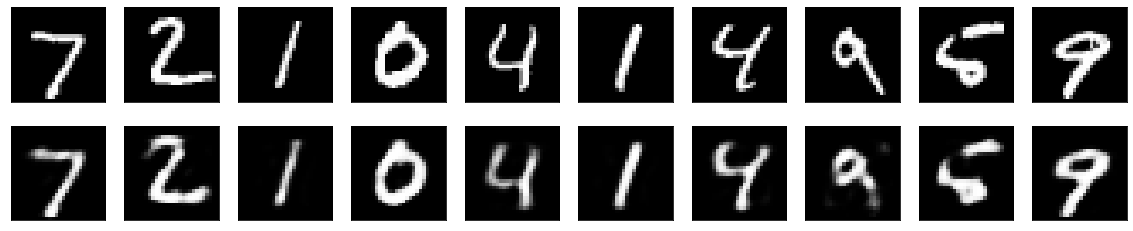

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
